In [1]:

import gzip
from collections import defaultdict
import math
import operator
import scipy.optimize
from sklearn import svm
import numpy as np
import string
import random
import string
from sklearn import linear_model
import warnings
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import scipy
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
class Utilites:
    def readGz(path):
        for l in gzip.open(path, 'rt',encoding='utf-8'):
            yield eval(l)

    def punctuations():
        return set(string.punctuation)

    def readCSV(path):
        f = gzip.open(path, 'rt')
        f.readline()
        for l in f:
            u, b, r = l.strip().split(',')
            r = int(r)
            yield u, b, r

    def Cosine(x1, x2):
        numer = 0
        norm1 = 0
        norm2 = 0
        for a1, a2 in zip(x1, x2):
            numer += a1*a2
            norm1 += a1**2
            norm2 += a2**2
        if norm1*norm2:
            return numer / math.sqrt(norm1*norm2)
        return 0

    def calcAcc(y, predY):
        assert( len(y) == len(predY))
        correct = np.array(y) == np.array(predY)
        return sum(correct) / len(correct)
    



In [2]:
users_review_data = []
reviews_data = []
users_items_data = []
items_data = []
bundle_data = []

for d in Utilites.readGz("user_reviews.json.gz"):
    users_review_data.append(d)

#for d in Utilites.readGz("/work/steam_reviews.json.gz"):
    #reviews_data.append(d)

for d in Utilites.readGz("users_items.json.gz"):
    users_items_data.append(d)

for d in Utilites.readGz("steam_games.json.gz"):
    items_data.append(d)

for d in Utilites.readGz("bundle_data.json.gz"):
    bundle_data.append(d)

In [3]:
users_items_train = []
users_items_validation = []
users_items_test = []
users_per_item_train = defaultdict(set)
items_per_user_train = defaultdict(set)
times_per_game_total = defaultdict()
times_per_game = defaultdict(list)


for d in users_items_data:
    games_played_by_user = d['items']
    random.shuffle(games_played_by_user)

    for i in range(len(games_played_by_user)):
        times_per_game[games_played_by_user[i]['item_id']].append(
            games_played_by_user[i]['playtime_forever'])
        if(games_played_by_user[i]['item_id'] in times_per_game_total):
            if(games_played_by_user[i]['playtime_forever'] != 0):
                times_per_game_total[games_played_by_user[i]['item_id']][0] += games_played_by_user[i]['playtime_forever']
                times_per_game_total[games_played_by_user[i]['item_id']][1] += 1
        else:
            times_per_game_total[games_played_by_user[i]['item_id']] = [games_played_by_user[i]['playtime_forever'],1]
        if(i < len(games_played_by_user) * 0.6):
            users_items_train.append((d['user_id'], games_played_by_user[i]))
            items_per_user_train[d['user_id']].add((games_played_by_user[i]['item_id'],games_played_by_user[i]['playtime_forever'],games_played_by_user[i]['playtime_2weeks']))
            users_per_item_train[games_played_by_user[i]['item_id']].add((d['user_id'],games_played_by_user[i]['playtime_forever'],games_played_by_user[i]['playtime_2weeks']))

        elif(i < len(games_played_by_user) * 0.8):
            users_items_validation.append((d['user_id'], games_played_by_user[i]))
        else:
            users_items_test.append((d['user_id'], games_played_by_user[i]))

games = defaultdict()
for d in items_data:
    if(d.__contains__('id')):
        games[d['id']] = d
    else:
        if(d['url'].split('/')[-1] != ''):
            games[d['url'].split('/')[-1]] = d


In [4]:
def prep_data(data):
    x =[]
    y = []
    for user,gameInfo in data:
        if(gameInfo['playtime_forever'] == 0): y.append(0)
        elif(gameInfo['playtime_forever'] <= 45): y.append(1)
        elif(gameInfo['playtime_forever'] <= 220): y.append(2)
        elif(gameInfo['playtime_forever'] <= 840): y.append(3)
        else: y.append(4)
        x.append((user,gameInfo['item_id']))
    return x, y

In [5]:
def prep_data2(data):
    x =[]
    y = []
    for user,gameInfo in data:
        if(gameInfo['playtime_forever'] <= 45): y.append(0)
        elif(gameInfo['playtime_forever'] <= 220): y.append(1)
        elif(gameInfo['playtime_forever'] <= 840): y.append(2)
        else: y.append(3)
        x.append((user,gameInfo['item_id']))
    return x, y

In [6]:
users_items_data[0]

{'user_id': '76561197970982479',
 'items_count': 277,
 'steam_id': '76561197970982479',
 'user_url': 'http://steamcommunity.com/profiles/76561197970982479',
 'items': [{'item_id': '17450',
   'item_name': 'Dragon Age: Origins',
   'playtime_forever': 4431,
   'playtime_2weeks': 0},
  {'item_id': '730',
   'item_name': 'Counter-Strike: Global Offensive',
   'playtime_forever': 23532,
   'playtime_2weeks': 0},
  {'item_id': '227780',
   'item_name': 'Serious Sam Classics: Revolution',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '12900',
   'item_name': 'Audiosurf',
   'playtime_forever': 115,
   'playtime_2weeks': 0},
  {'item_id': '260230',
   'item_name': 'Valiant Hearts: The Great War™ / Soldats Inconnus : Mémoires de la Grande Guerre™',
   'playtime_forever': 467,
   'playtime_2weeks': 0},
  {'item_id': '295690',
   'item_name': 'PARTICLE MACE',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '20500',
   'item_name': 'Red Faction: Guerrilla Ste

#### Visualize the distribution of data (time played by player)

Text(0, 0.5, 'Number of players')

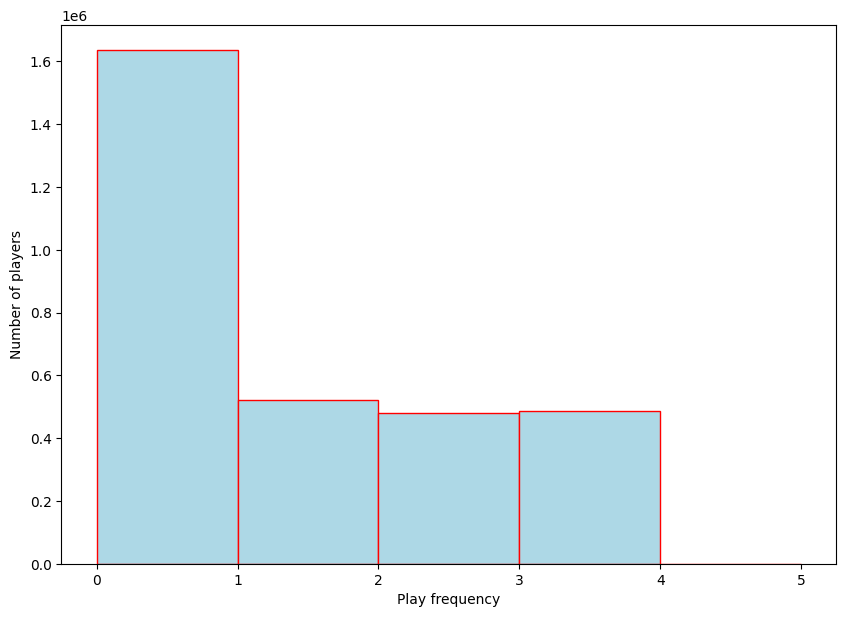

In [7]:
trainX, trainY = prep_data2(users_items_train)
valX, valY = prep_data2(users_items_validation)
testX, testY = prep_data2(users_items_test)
a = np.array(trainY)
plot, ax= plt.subplots(figsize =(10, 7))
threshold = []
for i in range(0,6,1):
    threshold.append(i)
plt.hist(a, bins=threshold,color = "lightblue", ec="red")
ax.set_xlabel("Play frequency")
ax.set_ylabel("Number of players")

Text(0, 0.5, 'Number of players')

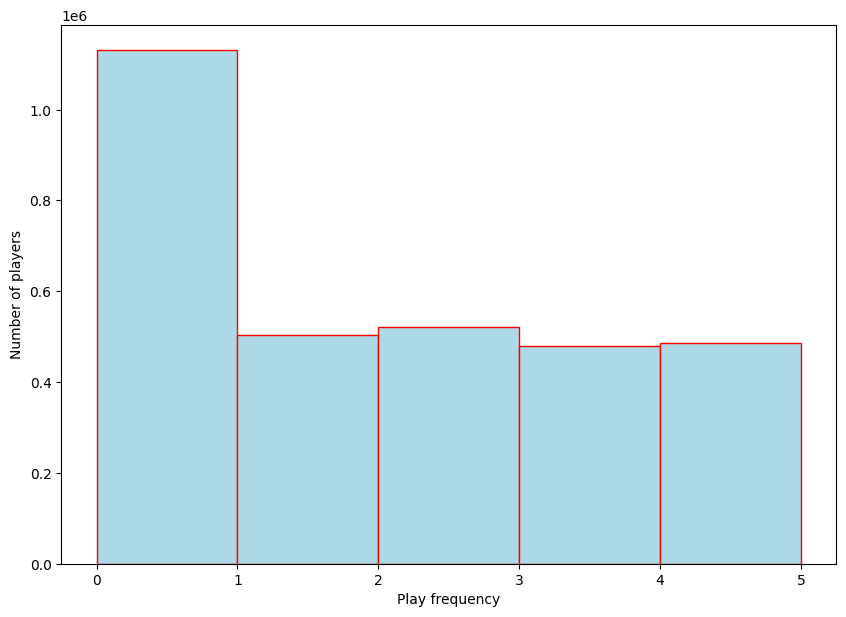

In [8]:
trainX, trainY = prep_data(users_items_train)
valX, valY = prep_data(users_items_validation)
testX, testY = prep_data(users_items_test)
a = np.array(trainY)
plot, ax= plt.subplots(figsize =(10, 7))
threshold = []
for i in range(0,6,1):
    threshold.append(i)
plt.hist(a, bins=threshold,color = "lightblue", ec="red")
ax.set_xlabel("Play frequency")
ax.set_ylabel("Number of players")


In [9]:
timesPerGameMean = {}
timesPerGameMedian = {}
timesPerCategory = defaultdict(list)
for game in times_per_game:
    timesPerGameMean[game] = np.mean(times_per_game[game])
    timesPerGameMedian[game] = np.median(times_per_game[game])
    if(game in games and 'genres' in games[game]):
        genres = games[game]['genres']
        for gameCategory in genres:
            timesPerCategory[gameCategory] += times_per_game[game]

In [10]:
timesPerTag = defaultdict(list)
for game in times_per_game:
    if(game in games and 'tags' in games[game]):
        genres = games[game]['tags']
        for gameCategory in genres:
            if(len(times_per_game) > 0):
                timesPerTag[gameCategory] += times_per_game[game]

In [11]:
timesPerCategoryMean = {}
timesPerCategoryMedian = {}
timesPerTagMean = {}
timesPerTageMedian = {}

for cat in timesPerCategory:
    timesPerCategoryMean[cat] = np.mean([ x for x in timesPerCategory[cat]])
    timesPerCategoryMedian[cat] = np.median([ x for x in timesPerCategory[cat]])

In [12]:
for tag in timesPerTag:
    timesPerTagMean[tag] = np.mean([ x for x in timesPerTag[tag]])
    timesPerTageMedian[tag] = np.median([ x for x in timesPerTag[tag]])

In [13]:
sortTagMean = sorted(timesPerTagMean.items(), key=lambda x: x[1], reverse=True)
sortTagMedian = sorted(timesPerTageMedian.items(), key=lambda x: x[1], reverse=True)


In [14]:
sortTagMean

[('Trading', 13317.038882464343),
 ('e-sports', 8554.963467316948),
 ('Animation & Modeling', 8551.106161532056),
 ('Diplomacy', 3864.4549180327867),
 ('Realistic', 3799.9161004952775),
 ('Military', 3713.5291758736394),
 ('Horses', 3626.7970736557995),
 ('Moddable', 3361.9517909202846),
 ('Fast-Paced', 3306.6195276318153),
 ('Competitive', 3270.5799982031017),
 ('Team-Based', 3113.391437954866),
 ('War', 3104.010412759733),
 ('Building', 2991.337777995014),
 ('Hex Grid', 2964.0102527264416),
 ('TrackIR', 2937.811225751343),
 ('Mod', 2915.1499021716672),
 ('PvP', 2872.4193277163727),
 ('PvE', 2766.015566677093),
 ('Ninja', 2569.0455286226475),
 ('Tactical', 2564.5519412083486),
 ('Online Co-Op', 2511.632651445859),
 ('Education', 2404.6982194681937),
 ('Grand Strategy', 2290.296353253937),
 ('Soccer', 2269.5864243786687),
 ('Football', 2205.661761257036),
 ('Artificial Intelligence', 2128.1410505836575),
 ('Heist', 2091.440405500766),
 ('Clicker', 2083.593951849677),
 ('Gun Customizati

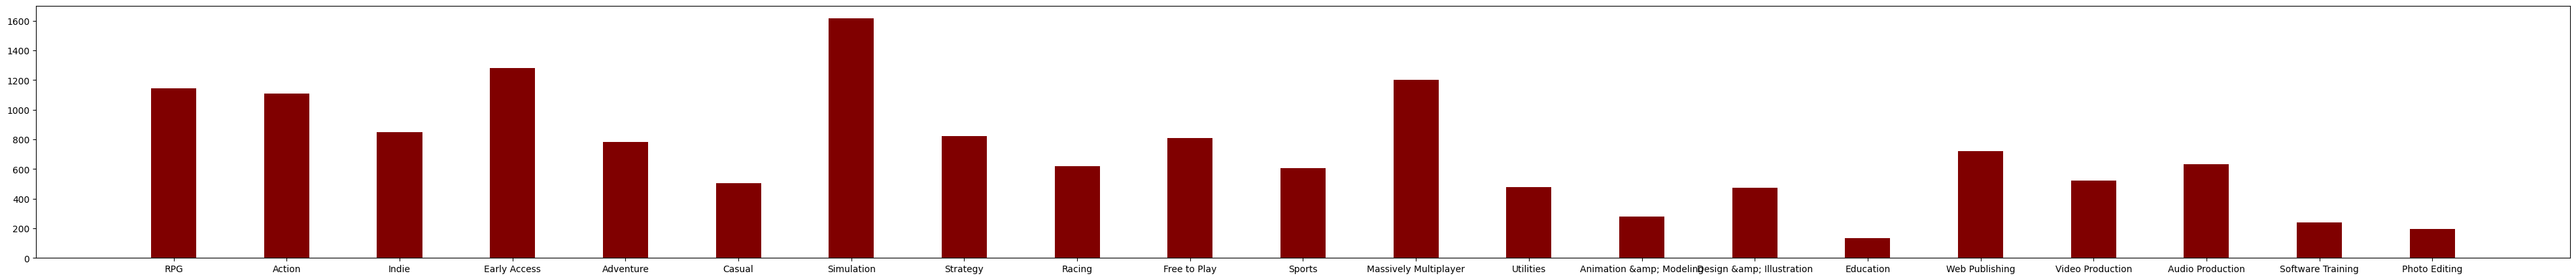

In [15]:
courses = list(timesPerCategoryMean.keys())
values = list(timesPerCategoryMean.values())
fig = plt.figure(figsize = (50, 5))

# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.show()  

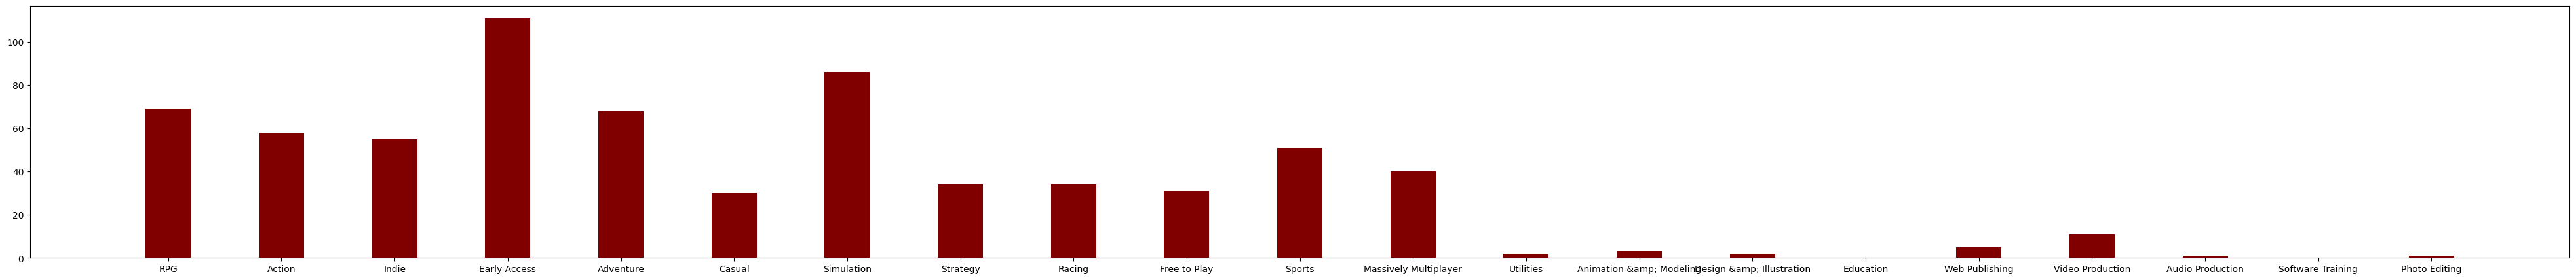

In [16]:
courses = list(timesPerCategoryMedian.keys())
values = list(timesPerCategoryMedian.values())
fig = plt.figure(figsize = (50, 5))

# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.show()  

In [17]:
pd.DataFrame.from_dict(timesPerTagMean,orient='index')

,0
RPG,1095.945258
Fantasy,670.249334
Story Rich,577.252640
Multiple Endings,450.984956
Singleplayer,971.512413
...,...
Steam Machine,108.834906
360 Video,12.142857
Foreign,104.727273
Feature Film,107.750000


In [18]:
def evalModel(model, dataX, dataY, args=[]):
    predY = model(dataX,args)
    acc = Utilites.calcAcc(predY, dataY)
    return acc

##### Trivial Predictor (always predict that a user never plays the game)

In [19]:
# Always predict that a user will never play a game
def modelPredTrivial(data, args={}):
    y_pred = [0] * len(data)
    return y_pred

##### Predict based on popularity of game (distance to mean time played)

In [20]:
def modelPredPopularityDifference(data,args={'mode':"mean"}):
    y_pred = []
    threshold = np.array([20, 45,220,840, 1460])
    for user, item in data:
        if(args['mode'] == "mean"):
            avg_time = timesPerGameMean[item]
        else:
            avg_time = timesPerGameMedian[item]
        diff = np.abs(threshold - avg_time)
        y_pred.append(np.argmin(diff))
    return y_pred

##### Predict based on popularity of game (based on paritcular threashold from mean time played)


In [21]:
def modelPredPopularityThreashold(data, args={'mode':"mean"}):
    y_pred = []
    for user, item in data:
        if(args['mode'] == "mean"):
            avg_time = timesPerGameMean[item]
        else:
            avg_time = timesPerGameMedian[item]
        if(avg_time == 0): y_pred.append(0)
        elif(0 < avg_time <= 45): y_pred.append(1)
        elif(avg_time <= 220): y_pred.append(2)
        elif(avg_time<= 840): y_pred.append(3)
        else: y_pred.append(4)
    return y_pred

In [22]:
def modelPredByPlayerTime(data, args={'mode':"median"}):
    y_pred = []
    for user, item in data:
        if(args['mode'] == "mean"):
            avg_time = np.mean([playtime for gameId, playtime, _ in  items_per_user_train[user]])
        else:
            avg_time = np.median([playtime for gameId, playtime, _ in  items_per_user_train[user]])
        if(avg_time < 20): 
            y_pred.append(0)
        elif(0 < avg_time <= 45): y_pred.append(1)
        elif(avg_time <= 220): y_pred.append(2)
        elif(avg_time<= 840): y_pred.append(3)
        else: y_pred.append(4)
    return y_pred

### Baseline prediction

In [28]:
args = {"mode":"mean"}
# Predict based on popularity
print(f'Popularity predictor(difference) acc: {evalModel(modelPredPopularityDifference,testX,testY,args)}')

# Predict based on popularity
print(f'Popularity predictor(threashold) acc: {evalModel(modelPredPopularityThreashold,testX,testY,args)}')

print(f'Popularity predictor(threashold) acc: {evalModel(modelPredByPlayerTime,testX,testY,args)}')

# Predict that a player that bought the game will never play it
print(f'Trivial predictor acc: {evalModel(modelPredTrivial,testX,testY,args)}')

Popularity predictor(difference) acc: 0.35450296073472115
Popularity predictor(threashold) acc: 0.26022039639423916
Popularity predictor(threashold) acc: 0.33536269623909365
Trivial predictor acc: 0.3632619464523564


In [29]:
args = {"mode":"median"}

# Predict based on popularity
print(f'Popularity predictor(difference) acc: {evalModel(modelPredPopularityDifference,testX,testY,args)}')

# Predict based on popularity
print(f'Popularity predictor(threashold) acc: {evalModel(modelPredPopularityThreashold,testX,testY,args)}')

print(f'Popularity predictor(threashold) acc: {evalModel(modelPredByPlayerTime,testX,testY,args)}')

# Predict that a player that bought the game will never play it
print(f'Trivial predictor acc: {evalModel(modelPredTrivial,testX,testY,args)}')




Popularity predictor(difference) acc: 0.41786916894895165
Popularity predictor(threashold) acc: 0.42575315404301173
Popularity predictor(threashold) acc: 0.33536269623909365
Trivial predictor acc: 0.3632619464523564


### Classifier prediction

In [26]:
trainX[0]

('76561197970982479', '17450')

In [ ]:
games['10']['genres']

['Action']

In [ ]:
all_genres = np.array(list(timesPerCategory.keys()))
genres = {}

In [ ]:
for x in range(len(all_genres)):
    genres[all_genres[x]] = x

In [ ]:
size = len(genres)
def oneHotEncodeCat(data):
    encode = np.zeros(size)
    for x in data:
        encode[genres[x]] = 1
    return encode

array([], dtype=float64)

In [ ]:
def prep_features(data):
    user = data[0]
    item = data[1]

    ## Genres of item
    # if(item in games and 'genres' in games[item]):
    #     feat = oneHotEncodeCat(games[item]['genres'])
    # else:
    #     feat = np.zeros(size)

    # Gloabal mean playtime for item
    feat = timesPerGameMedian[item]

    # Avg play time for player
    feat = np.append(feat,np.median([playtime for gameId, playtime, _ in  items_per_user_train[user]]))

    # Bias term
    feat = np.append(feat, 1)
    return feat

In [ ]:
train_X = [ prep_features(d) for d in trainX ]

In [ ]:
val_X = [ prep_features(d) for d in valX ]

In [ ]:
len(trainX)

3121051

In [ ]:
len(trainY)

3121051

In [ ]:
clf=linear_model.LogisticRegression( max_iter=1000,  verbose=1)
clf.fit(train_X, trainY)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.8s finished


LogisticRegression(max_iter=1000, verbose=1)

In [ ]:
predY = clf.predict(val_X)

In [ ]:
np.unique(predY)

array([0, 1, 2, 3])

In [ ]:
Utilites.calcAcc(predY, valY)

0.5832117163960994

In [ ]:
predY

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
np.mean([playtime for gameId, playtime, _ in  items_per_user_train['76561197970982479']])

753.4071856287425